In [99]:
import string
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
import nltk
from scipy.spatial.distance import cosine
from sklearn.metrics import roc_auc_score
%matplotlib inline
pal = sns.color_palette()

In [5]:
df_train = pd.read_pickle("train_pp.pkl")
df_test = pd.read_pickle("test_pp.pkl")

In [6]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,words_1,words_2,end_punc_1,end_punc_2,is_same_end_punc
145367,145367,229850,229851,Is there only one consciousness?,Is consciousness one for everyone?,1,"[is, there, only, one, consciousness, ?]","[is, consciousness, one, for, everyone, ?]",?,?,True
123169,123169,98309,199206,Which is a suitable solar panel installation p...,Which is a suitable solar panel installation p...,0,"[which, is, a, suitable, solar, panel, install...","[which, is, a, suitable, solar, panel, install...",?,?,True
57880,57880,101653,101654,Is there any idea for a new and useful mini pr...,Are there any new topics in computer science t...,0,"[is, there, any, idea, for, a, new, and, usefu...","[are, there, any, new, topic, in, computer, sc...",?,?,True
213043,213043,318261,318262,What does it mean if a girl cries after hurtin...,What does it mean if a girl cries without any ...,0,"[what, doe, it, mean, if, a, girl, cry, after,...","[what, doe, it, mean, if, a, girl, cry, withou...",?,?,True
204901,204901,307914,307915,What are some wholesale drop shippers that hav...,What portrait lenses are compatible with the C...,0,"[what, are, some, wholesale, drop, shipper, th...","[what, portrait, lens, are, compatible, with, ...",?,?,True


In [2]:
#use pre-trained:'Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)'
#vocab: 400K
# api.info("glove-wiki-gigaword-100")
word_vectors = api.load("glove-wiki-gigaword-100")

In [95]:
stop_words = set(nltk.corpus.stopwords.words("english")) #179 words in total 
#adding back some words which is crucial for this application
stop_words = stop_words.difference({"what","when","where","which","who","whom","how"})


In [96]:
len(stop_words)

172

In [61]:
def doc2vec(words):
    """
    simply adding word_vec for all words and compute means 
    all words should be in lower case; string.punctuations are skipped 
    words not in the word_vectors are skipped; 
    stop words are skipped 
    @param words: List[str]: a list of words
    return: 
    """
    sum_vec = np.zeros((word_vectors.vector_size,))
    cnt = 0 
    for w in words: 
        if not w in string.punctuation and not w in stop_words and w in word_vectors: 
            sum_vec = sum_vec + word_vectors[w]
            cnt += 1
    return sum_vec/cnt if cnt > 0 else sum_vec

In [62]:
def compute_distance(wv1,wv2): 
    """
    cosine distance
    @param wv1: word_vector
    @param wv2: word_vector
    return: float 
    """
    n_v1 = np.linalg.norm(wv1)
    n_v2 = np.linalg.norm(wv2)
    if n_v1 == 0.0 or n_v2 == 0.0: 
        return 0.0 if n_v1 == n_v2 else 2.0
    return cosine(wv1,wv2)    

In [97]:
f_qdist = lambda q1,q2: compute_distance(doc2vec(q1),doc2vec(q2)) 
df_train['qdist'] = df_train.apply(lambda row: f_qdist(row['words_1'],row['words_2']),axis=1)
df_test['qdist'] = df_test.apply(lambda row: f_qdist(row['words_1'],row['words_2']),axis=1)

In [81]:
np.percentile(df_train['qdist'],[0,5,10,25,50,75,90,95,100])

array([0.        , 0.        , 0.02038709, 0.0555436 , 0.11114994,
       0.20384298, 0.35349581, 0.47633876, 2.        ])

/home/sgu/miniconda3/envs/dl/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'test: qdist for is_dup=1 vs is_dup=0')

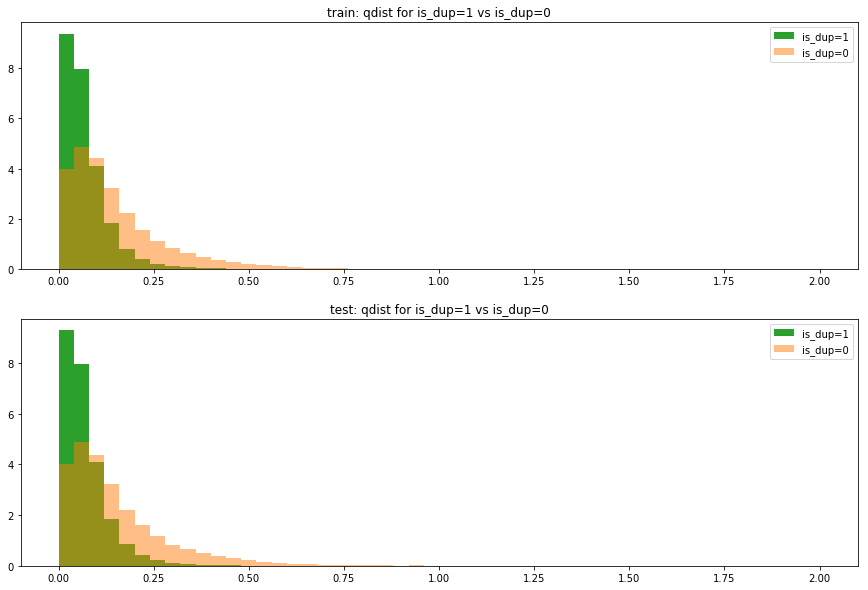

In [107]:
plt.figure(figsize=(15, 10))
plt.subplot(2,1,1)
sel_dup = df_train.is_duplicate == 1
plt.hist(df_train.loc[sel_dup,'qdist'], bins=50, range=[0, 2], color=pal[2], normed=True, label='is_dup=1')
plt.hist(df_train.loc[~sel_dup,'qdist'], bins=50, range=[0, 2], color=pal[1], normed=True, alpha=0.5, label='is_dup=0')
plt.legend()
plt.title("train: qdist for is_dup=1 vs is_dup=0")
plt.subplot(2,1,2)
sel_dup = df_test.is_duplicate == 1
plt.hist(df_test.loc[sel_dup,'qdist'], bins=50, range=[0, 2], color=pal[2], normed=True, label='is_dup=1')
plt.hist(df_test.loc[~sel_dup,'qdist'], bins=50, range=[0, 2], color=pal[1], normed=True, alpha=0.5, label='is_dup=0')
plt.legend()
plt.title("test: qdist for is_dup=1 vs is_dup=0")


In [108]:
#sanity check: what are the pair of zero qdist like? 
sel = df_train['qdist'] == 0.
df_train[sel].head()

,id,qid1,qid2,question1,question2,is_duplicate,words_1,words_2,end_punc_1,end_punc_2,is_same_end_punc,qdist
337973,337973,434644,349667,How can I introspect myself?,How do I introspect myself?,1,"[how, can, i, introspect, myself, ?]","[how, do, i, introspect, myself, ?]",?,?,True,0.0
64124,64124,111484,111485,I got denied by Google AdSense for 'insufficie...,I got denied by Google AdSense for 'insufficie...,0,"[i, got, denied, by, google, adsense, for, 'in...","[i, got, denied, by, google, adsense, for, 'in...",?,?,True,0.0
54372,54372,95997,95998,HOW DOESI FUCK A LADY?,How will I fuck a lady?,1,"[how, doesi, fuck, a, lady, ?]","[how, will, i, fuck, a, lady, ?]",?,?,True,0.0
356913,356913,58915,36758,How do I see who viewed my instagram videos?,How do I see who viewed any video on instagram?,1,"[how, do, i, see, who, viewed, my, instagram, ...","[how, do, i, see, who, viewed, any, video, on,...",?,?,True,0.0
87674,87674,147618,147619,What is the difference between electrical devi...,What is the difference between electronic devi...,1,"[what, is, the, difference, between, electrica...","[what, is, the, difference, between, electroni...",?,?,True,0.0


In [109]:
roc_auc_score(1.0 - df_train['is_duplicate'], df_train['qdist'])

0.7236865781452617

In [110]:
roc_auc_score(1.0 - df_test['is_duplicate'], df_test['qdist'])

0.7228852745883507